In [4]:
import argparse
import contextlib
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import SEACells

In [5]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style("ticks")
matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 100

In [6]:
data_dir = pathlib.Path.cwd().parent.parent / "data" / "current"

infile = data_dir / "SCPCP000001/SCPCS000001/SCPCL000001_processed_rna.h5ad"

In [7]:
ad = sc.read(infile)
ad

AnnData object with n_obs × n_vars = 2635 × 60319
    obs: 'barcodes', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'prob_compromised', 'miQC_pass', 'scpca_filter', 'sizeFactor', 'cluster', 'singler_celltype_ontology', 'singler_celltype_annotation', 'cellassign_celltype_annotation', 'cellassign_max_prediction', 'library_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'gene_ids', 'gene_symbol', 'mean', 'detected', 'feature_is_filtered'
    uns: 'X_name', 'af_num_cells', 'af_permit_type', 'af_resolution', 'alevinfry_version', 

In [8]:
# put the highly variable genes in a column of adata.var
ad.var["highly_variable"] = ad.var.gene_ids.isin(ad.uns["highly_variable_genes"])

In [9]:
# recompute principal components -
sc.tl.pca(ad, n_comps=50, mask_var="highly_variable")

In [10]:
n_SEACells = round(ad.n_obs / 75)  # recommended number of seacells
n_waypoint_eigs = 10  # Number of eigenvalues to consider when initializing metacells

In [11]:
model = SEACells.core.SEACells(
    ad,
    build_kernel_on="X_pca",
    n_SEACells=n_SEACells,
    n_waypoint_eigs=n_waypoint_eigs,
    convergence_epsilon=1e-5,
)

Welcome to SEACells!


In [12]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2635 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2635 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2635 [00:00<?, ?it/s]

Constructing CSR matrix...


/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


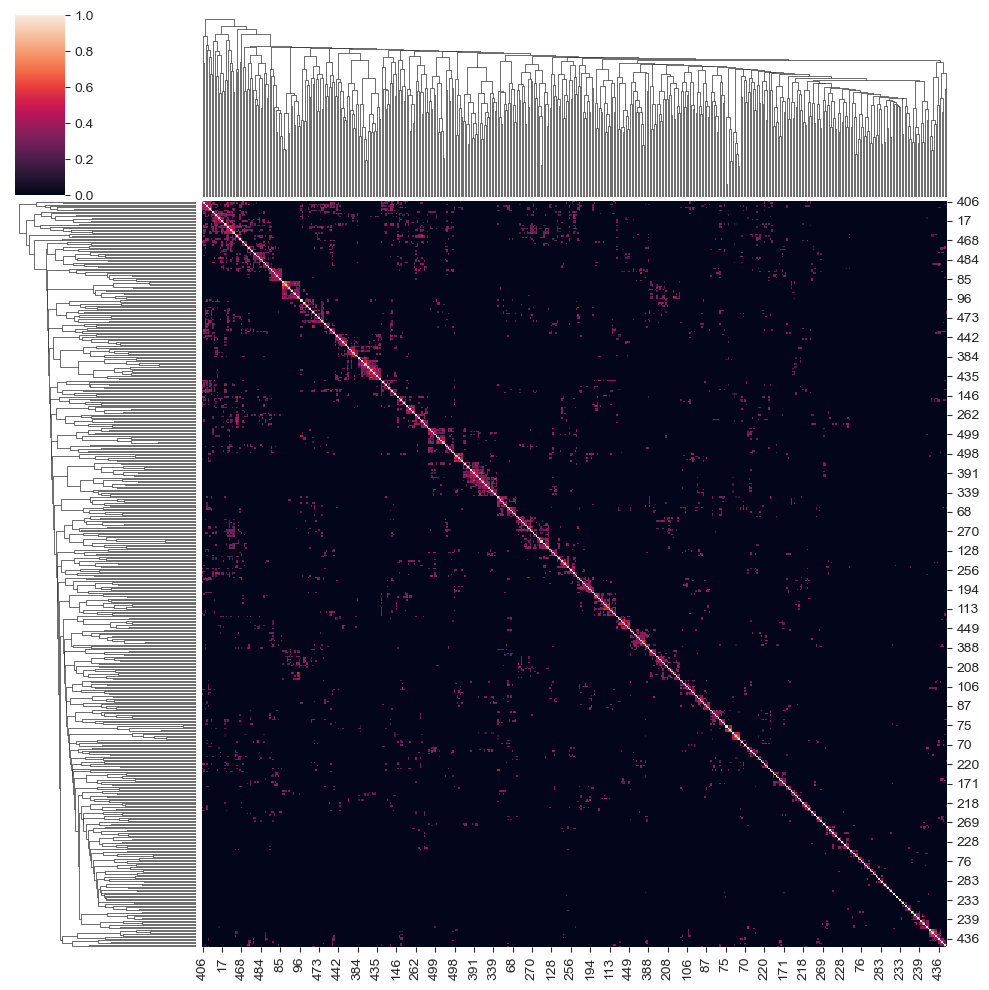

In [13]:
sns.clustermap(M.toarray()[:500, :500])

In [14]:
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 26 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 19/19 [00:00<00:00, 1239.72it/s]

Selecting 9 cells from greedy initialization.


In [15]:
ad.obsm["X_PCA"]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
TGGATGTTCAACTTTC,-1.584546,-10.880488,-14.166064,-7.692556,4.201132,5.894226,1.936048,-3.294648,-4.196984,-0.205761,...,-0.493365,1.213576,-0.579431,-0.600489,0.790481,-0.544944,0.206023,0.042157,0.054998,-1.168591
TTATTGCGTGAGTGAC,17.024030,-6.086985,-22.824804,4.775480,-0.924375,-0.922051,6.397592,1.454533,0.605211,-1.246259,...,0.531564,0.379813,0.554974,-1.537091,0.037954,0.382407,0.570639,-0.036725,0.426309,-0.342694
AGATGCTAGAGCACTG,10.735237,-7.308715,-10.237141,-12.083304,2.052230,5.543146,-2.116362,-0.090588,-1.555968,-1.551976,...,-0.024266,0.732428,-0.833517,-0.138165,0.640257,1.045229,-0.315078,0.402583,0.166635,-0.706989
TGATGGTGTTGGATCT,15.307713,-13.309712,-17.952868,-0.381825,-7.365766,2.562808,-3.346807,2.232833,-0.451776,-4.159963,...,-0.306719,0.254560,-0.380890,-0.383836,0.986370,-0.725501,-0.112383,-0.829718,-0.870934,0.243348
GGTTAACTCCTCACTG,3.911552,-11.715873,-15.707089,-2.360590,10.477219,7.444513,0.899458,-4.158401,-5.949216,0.103379,...,-0.775087,0.596840,-0.373671,-0.444968,1.054865,0.715076,1.097403,-0.701235,-0.114777,-0.323656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGTTAGAAGACTTGTC,25.687015,1.165546,18.331972,2.074126,-0.404586,-1.560871,0.844183,-0.440739,-0.561791,3.378099,...,-2.785311,-0.120230,1.728569,0.516131,-1.323919,-0.031783,-0.059270,0.031586,-0.762438,1.501116
CGCATAACAGCTGTGC,8.981669,28.241342,20.025349,-1.434262,-5.818299,-5.981952,-4.930664,-21.522059,1.237486,-3.620023,...,0.616652,2.880805,1.701011,-13.865649,-0.888379,1.742418,-4.586125,5.253393,1.144513,-0.778658
AGGCATTAGCGACATG,-3.086946,15.339439,24.677999,4.028867,0.300040,2.201004,1.889367,8.761190,-8.845645,-2.206675,...,-1.500987,2.365160,1.198715,-2.961514,-7.569550,1.360433,-2.744426,-1.326261,-3.304403,-3.495085
TCTCACGAGGACGGAG,25.390145,2.047251,17.886098,1.163481,1.355145,11.966202,1.849367,-0.763884,4.186178,-2.580343,...,0.965720,3.415326,3.086866,-0.375421,2.077019,0.257634,1.163290,0.161772,4.537665,-4.822955


In [16]:
sc.tl.umap(ad)
ad

AnnData object with n_obs × n_vars = 2635 × 60319
    obs: 'barcodes', 'sum', 'detected', 'subsets_mito_sum', 'subsets_mito_detected', 'subsets_mito_percent', 'total', 'prob_compromised', 'miQC_pass', 'scpca_filter', 'sizeFactor', 'cluster', 'singler_celltype_ontology', 'singler_celltype_annotation', 'cellassign_celltype_annotation', 'cellassign_max_prediction', 'library_id', 'sample_id', 'scpca_project_id', 'submitter_id', 'participant_id', 'submitter', 'age', 'sex', 'diagnosis', 'subdiagnosis', 'tissue_location', 'disease_timing', 'organism', 'is_xenograft', 'is_cell_line', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'organism_ontology_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'gene_ids', 'gene_symbol', 'mean', 'detected', 'feature_is_filtered', 'highly_variable'
    uns: 'X_name', 'af_num_cells', 'af_permit_type', 'af_resolution', 'a

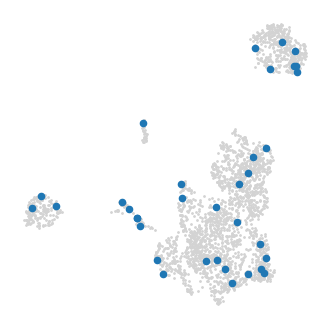

In [17]:
SEACells.plot.plot_initialization(ad, model)

In [18]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00090
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 33 iterations.


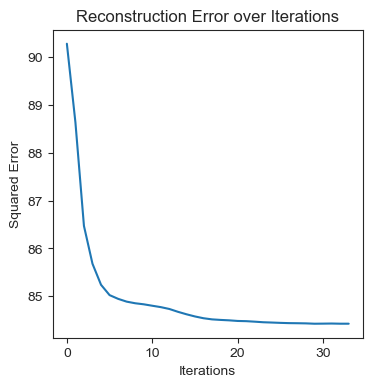

In [19]:
# Check for convergence
model.plot_convergence()

In [20]:
ad.obs[["SEACell"]].head()

,SEACell
index,
TGGATGTTCAACTTTC,SEACell-24
TTATTGCGTGAGTGAC,SEACell-2
AGATGCTAGAGCACTG,SEACell-25
TGATGGTGTTGGATCT,SEACell-9
GGTTAACTCCTCACTG,SEACell-19


/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/SEACells/plot.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby('SEACell').mean().reset_index()
/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


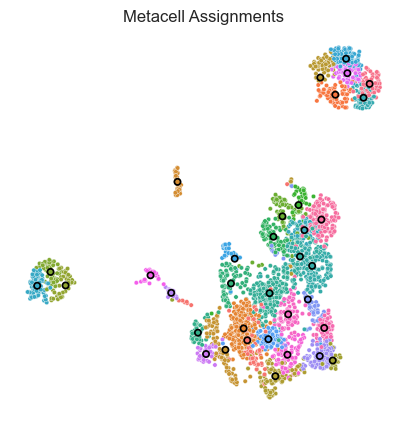

In [21]:
SEACells.plot.plot_2D(ad, key="X_umap", colour_metacells=True)

/Users/josh/.conda/envs/openscpca-metacells/lib/python3.11/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


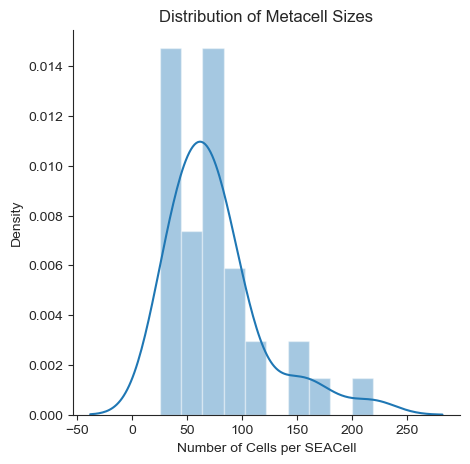

,size
SEACell,
SEACell-0,64
SEACell-1,58
SEACell-10,65
SEACell-11,219
SEACell-12,38
SEACell-13,88
SEACell-14,65
SEACell-15,99
SEACell-16,25


In [22]:
SEACells.plot.plot_SEACell_sizes(ad, bins=10)

In [23]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(
    ad, "singler_celltype_ontology"
)
SEACell_purity.head()

,singler_celltype_ontology,singler_celltype_ontology_purity
SEACell,,
SEACell-0,CL:0000540,0.950000
SEACell-1,CL:0000540,0.964912
SEACell-10,CL:0000540,0.883333
SEACell-11,CL:0000540,1.000000
SEACell-12,CL:0000235,0.968750


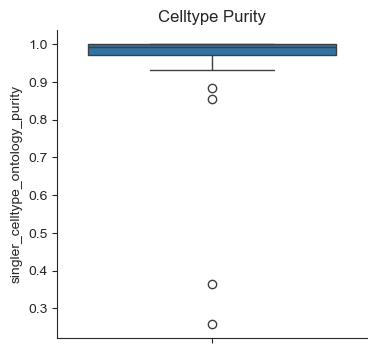

In [24]:
plt.figure(figsize=(4, 4))
sns.boxplot(data=SEACell_purity, y="singler_celltype_ontology_purity")
plt.title("Celltype Purity")
sns.despine()
plt.show()
plt.close()

In [35]:
type(ad.obsm["X_UMAP"])

ad.shape[0]

2635